In [1]:
import tensorflow as tf
import glob # 获取路径
import tensorflow.keras as keras
from matplotlib import pyplot as plt # 绘图
%matplotlib inline
AUTOTUNE = tf.data.experimental.AUTOTUNE # prefetch 根据CPU个数创建读取线程
import os

In [2]:
tf.__version__

'2.1.0'

In [3]:
os.listdir('./')

['.ipynb_checkpoints', 'trainA', 'cycleGAN.ipynb', 'trainB']

In [4]:
img_ori =glob.glob('./trainA/*jpg') #all apple image to convert to original

In [5]:
len(img_ori)

995

In [6]:
img_target = glob.glob('./trainB/*jpg') # all orange images

In [7]:
len(img_target)

1019

In [8]:
# 图此读取&解码函数
def read_jpg(path):
    img = tf.io.read_file(path)# 2.0里面的读取都在io里面
    img = tf.image.decode_jpeg(img,channels = 3)
    return img
    

In [9]:
def load_img(path):
    img = read_jpg(path)
    img = tf.image.resize(img,(256,256)) # resize 会使得在后续显示的时候不是none none
    img = img/127.5-1
    return img

In [10]:
# 创建dataset
train_a = tf.data.Dataset.from_tensor_slices(img_ori)
train_b = tf.data.Dataset.from_tensor_slices(img_target)

In [11]:
buffer_size  = 200

In [12]:
#dataset 按照load_img 来加载
train_a = train_a.map(load_img,num_parallel_calls = AUTOTUNE).cache().shuffle(buffer_size).batch(1)

train_b= train_b.map(load_img,num_parallel_calls = AUTOTUNE).cache().shuffle(buffer_size).batch(1)
#cache的作用是缓存，缓存可以大大提高读取的效率 在cache里面添加路径参数，可以将下一批将要读取的数据缓存到此路径中
#batch 为1 是因为不同的图片可以是局部或者全部处理，每一张图片都有自己的转换风格的方式，所以要一张一张来处理

In [13]:
# zip函数 创建了数据 有两部分数据 
data_train = tf.data.Dataset.zip((train_a,train_b)) 

In [14]:
data_train

<ZipDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

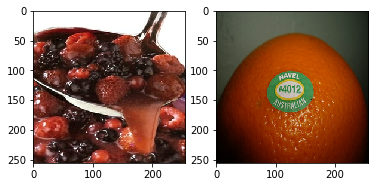

In [15]:
for apple,orange in data_train.take(1):
       plt.subplot(1,2,1) # 三个参数分别表示：表示画 1行2 列 中的第1个
       plt.imshow(keras.preprocessing.image.array_to_img(apple[0])) # 从array 转换为img
       plt.subplot(1,2,2)
       plt.imshow(keras.preprocessing.image.array_to_img(orange[0])) # 从array 转换为img

In [16]:
# 类似于batchNornalization 的 Instance normalization，后者非常适合style transfer，直接对一张图片进行归一化；
# BN适用于判别器，比如对图片进行分类；因为BN注重于对每个batch进行归一化，从而保证数据分布的一致性，
#而判别器模型的结果正式取决于数据的整体分布，我们希望此批次的分布和整体数据额分布是一致的

#BN对batch的size大小比较敏感，由于每次计算的 均值和方差是在一个batch上，若batchsize太小，则计算的均值和方差不足以代表整体的数据分布

#Batch size 在内存显存允许的情况下 越大越好

In [17]:
# instance  noramlization 封装爱tensorflow_addons
# bacth(1)的原因
#IN 适用于生成器，比如图片的风格迁移，因为每张图片的风格不同，对整个batch进行归一化不适合图像风格化，使用IN不仅可以加速模型手链，
#并且可以保持每张图像实例之间的独立性

#实际上是对单张图片 沿着channel进行均值和方差的计算

In [18]:
#!pip --default-timeout=1000 install -i https://pypi.tuna.tsinghua.edu.cn/simple  tensorflow_addons
import tensorflow_addons as tfa

In [19]:
def downsample(filters,size):# 卷积核个数和大小
    result = keras.Sequential()#顺序模型的创建
    result.add(keras.layers.Conv2D(filters,size,strides = 2,padding='same',
                                   use_bias = False)
              )
    result.add(tfa.layers.InstanceNormalization())
    result.add(keras.layers.LeakyReLU())
    return result

In [20]:
def upsample(filters,size,drop=False):# 卷积核个数和大小,上采样过程中 为了过拟合 添加drop
    result = keras.Sequential()#顺序模型的创建
    result.add(keras.layers.Conv2DTranspose(filters,size,strides = 2,padding='same',
                                   use_bias = False)
              )
    result.add(tfa.layers.InstanceNormalization())
    if drop:
         result.add(keras.layers.Dropout(0.5))   
    result.add(keras.layers.ReLU())
    return result

In [21]:
# 生成器使用改进的u-net模型的变形
def generator():
    inputs = keras.layers.Input(shape=[256,256,3])
    down_stack=[
        downsample(64,4), #128
        downsample(128,4),#64
        downsample(256,4),#32
        downsample(512,4),#16
        
        downsample(512,4),#8
        downsample(512,4),#4
        downsample(512,4),#2
        downsample(512,4),#1
    ]
    
    up_stack=[
        upsample(512,4,drop=True),#2
        upsample(512,4,drop=True),#4
        upsample(512,4,drop=True),#8
        upsample(512,4,drop=True),#16
        
        upsample(256,4),#32
        upsample(128,4),#64
        upsample(64,4),#128
    ]
    last = keras.layers.Conv2DTranspose(3,4,strides = 2,padding ='same',activation='tanh')# 输出层使用tanh激活到【-1,1】
    lists = []
    x = inputs
    for down in down_stack:
        x = down(x)
        lists.append(x)
       
    lists = reversed(lists  [:-1])# 不要最后一层 并且翻转
    for up,skip in zip(up_stack,lists):
        x = up(x)
        x = keras.layers.Concatenate()([x,skip]) # 通道数增加一倍
        
    x = last(x)
    # 创建模型并且输出
    return keras.Model(inputs = inputs,outputs = x)
    
    

In [22]:
gen = generator()

In [23]:
def discriminator():
    inputs  = keras.layers.Input(shape=[256,256,3])
    down1 = downsample(64,4)(inputs)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)#32
    # patch gan 很适合对图像的一部分进行判别
    # 首先填充
    zero_pad1 = keras.layers.ZeroPadding2D()(down3)  # 上下左右各添加一行、列0，变成34*34*256
    
    conv = keras.layers.Conv2D(512,4,strides = 1)(zero_pad1)  # 31*31*512 ,padding为valid
    norm = tfa.layers.InstanceNormalization()(conv)
    leakrelu = keras.layers.LeakyReLU()(norm)
    
    zero_pad2 = keras.layers.ZeroPadding2D()(leakrelu)  # 上下左右各添加一行、列0，变成33*33*256
    
    last = keras.layers.Conv2D(1,4,strides = 1)(zero_pad2)  # 30*30*512 ,padding为valid ,即为 33-（4-1）
    
    return keras.Model(inputs = inputs,outputs = last)

In [24]:
disc =discriminator()

In [25]:
# 损失函数 和 优化函数
# 判别器损失 生成器损失 循环一致损失，生成的橘子的苹果图像反回去的时候 和原始的苹果图像一致的差距

loss_obj =keras.losses.BinaryCrossentropy() # 二元交叉熵损失


In [26]:
def dis_loss(real_image,gen_image):
    real_loss = loss_obj(tf.ones_like(real_image),real_image)
    gen_loss = loss_obj(tf.zeros_like(gen_image),gen_image)
    return real_loss+gen_loss

In [27]:
def gen_loss(gen_image):
    gen_loss = loss_obj(tf.ones_like(gen_image),gen_image)# 希望可以骗过生成器
    #循环一致损失
    return gen_loss

In [28]:
def cycle_loss(real_img,cycled_img):
    return tf.reduce_mean(tf.abs(real_img-cycled_img))*7 # 也可以使用二阶（tf.square）损失，还有percistance loss 计算高阶特征时间的损失

In [29]:
# 两个生成器 和 两个判别器
#优化器
gen_x_ops = keras.optimizers.Adam(2e-4,beta_1=0.5)
gen_y_ops = keras.optimizers.Adam(2e-4,beta_1=0.5)
disc_x_ops = keras.optimizers.Adam(2e-4,beta_1=0.5)
disc_y_ops = keras.optimizers.Adam(2e-4,beta_1=0.5)

In [30]:
def show_image(model,test_input):
    prediction = model(test_input,training=True)
    plt.figure(figsize =(15,15))
    display_list = [test_input[0],prediction[0]]
    titles = ['input','predicted']
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()    
    

In [31]:
# gen_x : appleA to orangeA
# gen_y : orangeA to appleA'
# disc_x : 是否是真实的apple 主要针对生成的appleA‘
# disc_y:  是否是真实的orange，主要是针对生成的orangeA

gen_x = generator()
gen_y = generator()
disc_x = discriminator()
disc_y = discriminator() 
    
    

In [32]:
#因为是一个循环的调用 密集的运算，可以定义为一个图运算
@tf.function
def train_step(image_a,image_b):
    #persistent true 为了重复计算梯度
    with tf.GradientTape(persistent=True) as tape:
        
        print('1')
        fake_b = gen_x(image_a)
        
        cycle_a = gen_y(fake_b)
        
        fake_a = gen_y(image_b)
        
        cycle_b = gen_x(fake_a)
        
        disc_real_a  = disc_x(image_a)
        disc_fake_a = disc_x(fake_a)
        
        disc_real_b = disc_y(image_b)
        disc_fake_b = disc_y(fake_b)
        
        disc_loss_x  =  dis_loss(disc_real_a,disc_fake_a) # z主要判别真假图片a 两张图片之间没有输入输出的因果关系
        disc_loss_y = dis_loss(disc_real_b,disc_fake_b)
        
#         disc_loss_x_fake =  dis_loss(image_a,disc_real_a)
#         disc_loss_y_fake = dis_loss(image_b,disc_real_b)
        
        gen_loss_x = gen_loss(fake_b)
        gen_loss_y = gen_loss(fake_a)
        
        
        print('2')
        cycle_loss_ = cycle_loss(image_a,cycle_a) + cycle_loss(image_b,cycle_b) 
        
        total_gen_x_loss = gen_loss_x+cycle_loss_
        total_gen_y_loss = gen_loss_y+cycle_loss_
    print('3')    
    gen_x_gradient = tape.gradient(total_gen_x_loss,gen_x.trainable_variables)
    gen_y_gradient = tape.gradient(total_gen_y_loss,gen_y.trainable_variables)
    disc_x_gradient = tape.gradient(disc_loss_x,disc_x.trainable_variables)
    disc_y_gradient = tape.gradient(disc_loss_y,disc_y.trainable_variables)
    
    # 根据梯度 优化参数
    gen_x_ops.apply_gradients(zip(gen_x_gradient,gen_x.trainable_variables))
    gen_y_ops.apply_gradients(zip(gen_y_gradient,gen_y.trainable_variables))
    disc_x_ops.apply_gradients(zip(disc_x_gradient,disc_x.trainable_variables))
    disc_y_ops.apply_gradients(zip(disc_y_gradient,disc_y.trainable_variables))
    print('4')    
        
        
    

In [33]:
epochs = 300

In [34]:
def fit(train_ds,epochs):
    i = 0;
    for epoch in range(epochs):
        print("epoch={}".format(epoch))
        for a,b in train_ds:
            train_step(a,b)
            print("i={}".format(i))
            if i%10 == 0:
                print('.',end='')
#                 for aa,bb in train_ds.take(1):
#                     show_image(gen_x,aa)
#                     show_image(gen_y,bb)
            i+=1
        if epoch%1==0:
            for aa,bb in train_ds.take(1):
                show_image(gen_x,aa)
                show_image(gen_y,bb)
                gen_x.save('gen_x.h5')
                gen_y.save('gen_y.h5')
        

In [ ]:
fit(data_train,epochs)

epoch=0
1
2
3
4
1
2
3
4
i=0
.i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
.i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
.i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
.i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
.i=41
i=42
i=43
i=44
i=45
i=46
i=47
i=48
i=49
i=50
.i=51
i=52
i=53
i=54
i=55
i=56
i=57
i=58
i=59
i=60
.i=61
i=62
i=63
i=64
i=65
i=66
i=67
i=68
i=69
i=70
.i=71
i=72
i=73
i=74
i=75
i=76
i=77
i=78
i=79
i=80
.i=81
i=82
i=83
i=84
i=85
i=86
i=87
i=88
i=89
i=90
.i=91
i=92
i=93
i=94
i=95
i=96
i=97
i=98
i=99
i=100
.i=101
i=102
i=103
i=104
i=105
i=106
i=107
i=108
i=109
i=110
.i=111
i=112
i=113
i=114
i=115
i=116
i=117
i=118
i=119
i=120
.i=121
i=122
i=123
i=124
i=125
i=126
i=127
i=128
i=129
i=130
.i=131
i=132
i=133
i=134
i=135
i=136
i=137
i=138
i=139
i=140
.i=141
i=142
i=143
i=144
i=145
i=146
i=147
i=148
i=149
i=150
.i=151
i=152
i=153
i=154
i=155
i=156
i=157
i=158
i=159
i=160
.i=161
i=162
i=163
i=164
i=165
i=166
i=167
i=168
i=169
i=170
.i=171
i=172
i=173
i=174
i=175
i=176
i=177
